In [1]:
! pip install -r ../requirements.txt


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import torch
import copy
import math
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.expanduser("~/repos/NeurOps/pytorch"))
from neurops import *

from growprune import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/kaitlin/repos/NeurOps/pytorch/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kaitlin/repos/NeurOps/pytorch/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
hidden = [32]
regression = False

base_data = ToyData(64, 32, 5000, regression=regression)
train_loader, val_loader, test_loader = split_dataset(base_data, val_size = 0.1, test_size = 0.1, batch_size = 128)



model = ModSequential(
        ModLinear(64, hidden[0], masked=True, prebatchnorm=True, learnable_mask=True),
        #ModLinear(hidden[0], hidden[1], masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(hidden[0], 1 if regression else 2, masked=True, prebatchnorm=True),
        track_activations=True,
        track_auxiliary_gradients=True
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() if regression else torch.nn.CrossEntropyLoss()

print("This model has {} effective parameters.".format(model.parameter_count(masked = True)))
#print("The conversion factor of this model is {} after layer {}.".format(model.conversion_factor, model.conversion_layer))

This model has 2178 effective parameters.


In [3]:
pre_losses, pre_accs = train(model, train_loader, optimizer, criterion, epochs=50, val_loader=val_loader, device=device, regression=regression, verbose=False, val_verbose=False)

In [4]:
#modded_data = copy.deepcopy(base_data)
#modded_data.shift_distribution(-1, 100)
#modded_train_loader, modded_val_loader, modded_test_loader = split_dataset(modded_data, val_size = 0.1, test_size = 0.1, batch_size = 128)

Training 32 epochs per shift, shifting window by 32 indices 2 times
tensor(0.0022)
tensor(-0.0022)


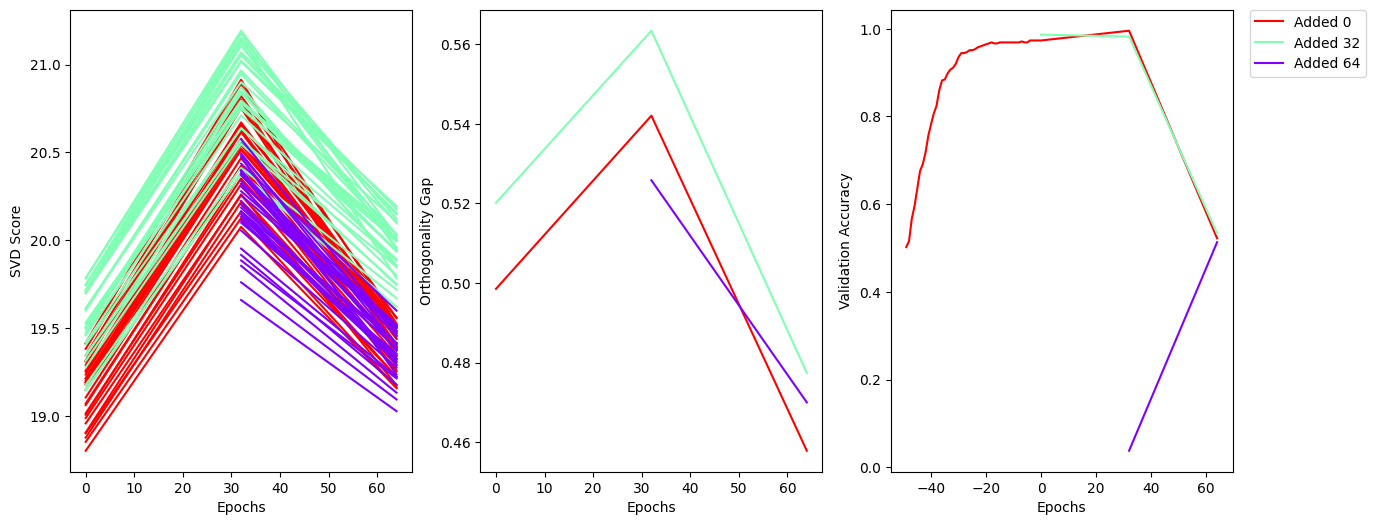

Training 16 epochs per shift, shifting window by 16 indices 4 times
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)


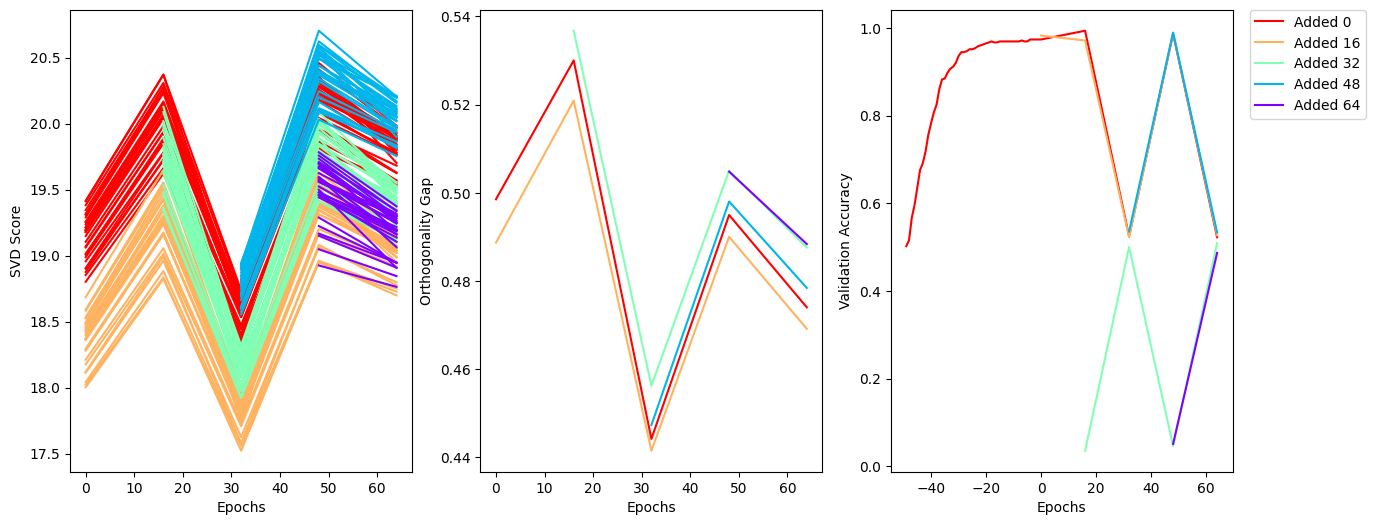

Training 8 epochs per shift, shifting window by 8 indices 8 times
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)


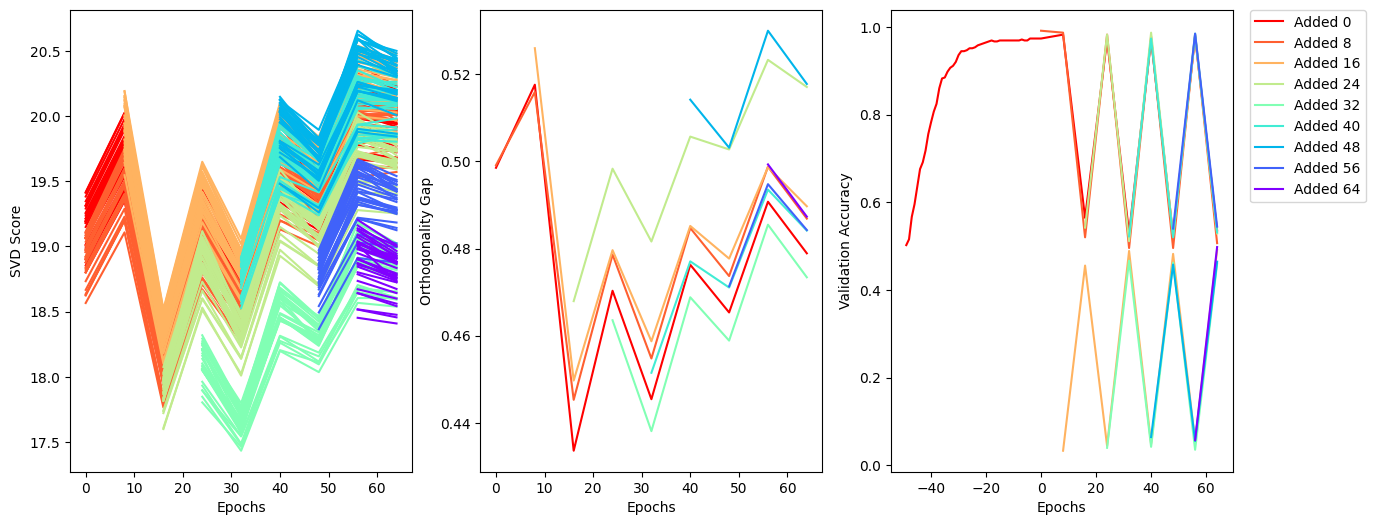

Training 4 epochs per shift, shifting window by 4 indices 16 times
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)
tensor(0.0022)
tensor(-0.0022)


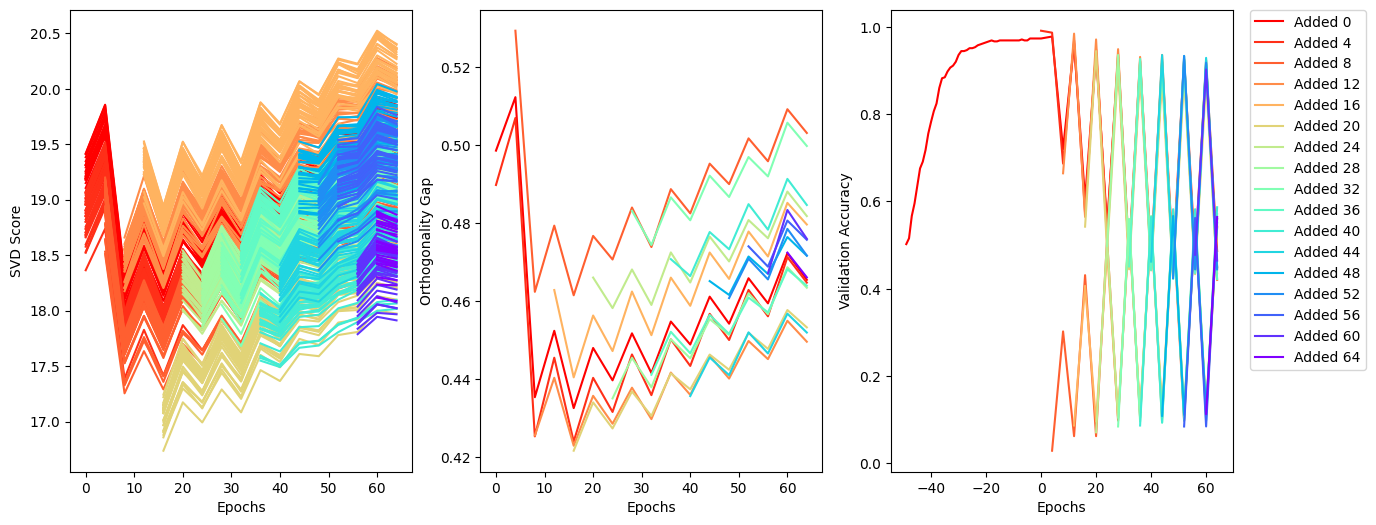

In [6]:
cmap = plt.get_cmap('rainbow')

for power in range(int(math.log(base_data.input_dim, 2))-2):
    mod = copy.deepcopy(model)
    mod_optimizer = torch.optim.SGD(mod.parameters(), lr=0.01)
    mod_optimizer.load_state_dict(optimizer.state_dict())

    loss, acc = test(mod, val_loader, criterion, device=device, regression=regression, verbose=False)
    accs = [list(pre_accs)]
    svd_scores = [svd_score(mod.activations["0"]).unsqueeze(0)]
    orthog_gaps = [[orthogonality_gap(mod.activations["0"])]]

    timestamp = list(range(-50, 1))

    shift = 2**(int(math.log(base_data.input_dim, 2))-power-1)
    datasets = [val_loader]
    
    print("Training {} epochs per shift, shifting window by {} indices {} times".format(64//int(base_data.input_dim/shift), shift, int(base_data.input_dim/shift)))
    for step in range(int(base_data.input_dim/shift)):
        modded_data = copy.deepcopy(base_data)
        modded_data.shift_distribution(multiplier=(-1)**step, recompute_y=False)
        #modded_data.shift_distribution(adder=((step+1)*shift)/32, recompute_y=False)
        #modded_data.shift_window((step+1)*shift)
        print(modded_data.X.mean())
        modded_train_loader, modded_val_loader, modded_test_loader = split_dataset(modded_data, val_size = 0.1, test_size = 0.1, batch_size = 128)
        datasets.append(modded_val_loader)
        loss, acc = test(mod, modded_val_loader, criterion, device=device, regression=regression, verbose=False)
        accs.append([acc])
        svd_scores.append(svd_score(mod.activations["0"]).unsqueeze(0))
        orthog_gaps.append([orthogonality_gap(mod.activations["0"])])
        train(mod, modded_train_loader, mod_optimizer, criterion, epochs=64//int(base_data.input_dim/shift), val_loader=modded_val_loader, device=device, regression=regression, verbose=False, val_verbose=False)
        timestamp.append(timestamp[-1]+64//int(base_data.input_dim/shift))
        for i, vl in enumerate(datasets):
            loss, acc = test(mod, vl, criterion, device=device, regression=regression, verbose=False)
            accs[i].append(acc)
            svd_scores[i] = torch.cat((svd_scores[i], svd_score(mod.activations["0"]).unsqueeze(0)), dim=0)
            orthog_gaps[i].append(orthogonality_gap(mod.activations["0"]))

    #plot the svd scores
    colors = [cmap(i) for i in np.linspace(1, 0, len(svd_scores))]
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
    for i, scores in enumerate(svd_scores):
        for neuron in range(scores.shape[1]):
            ax1.plot(timestamp[-len(scores[:,neuron]):], scores[:,neuron], color=colors[i], label="Window {}".format(int(i*(64//(len(svd_scores)-1)))) if neuron == 0 else None)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("SVD Score")
    for i, gaps in enumerate(orthog_gaps):
        ax2.plot(timestamp[-len(gaps):], gaps, color=colors[i], label="Added {}".format(int(i*(64//(len(svd_scores)-1)))))
        ax3.plot(timestamp[-len(accs[i]):], accs[i], color=colors[i], label="Added {}".format(int(i*(64//(len(svd_scores)-1)))))
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Orthogonality Gap")
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("Validation Accuracy")
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    #print(datasets[0].dataset.y == datasets[-1].dataset.y)

-1: 149.421 0.1	0: 49.525 0.4	1: 9.108 0.9	
tensor([0.1658, 0.1058, 0.1535, 0.0828, 0.0946, 0.1927, 0.1510, 0.1303, 0.1916,
        0.1472, 0.1323, 0.1504, 0.4767, 0.6599, 0.0245, 0.0244, 0.1056, 0.0506,
        0.1632, 0.4092, 0.0488, 0.2861, 0.1451, 0.1183, 0.1679, 0.2682, 0.1727,
        0.1584, 0.2954, 0.1310, 0.0359, 0.1427])
Training 32 epochs per shift, shifting window by 32 indices 2 times
52 53
3 53
2 53


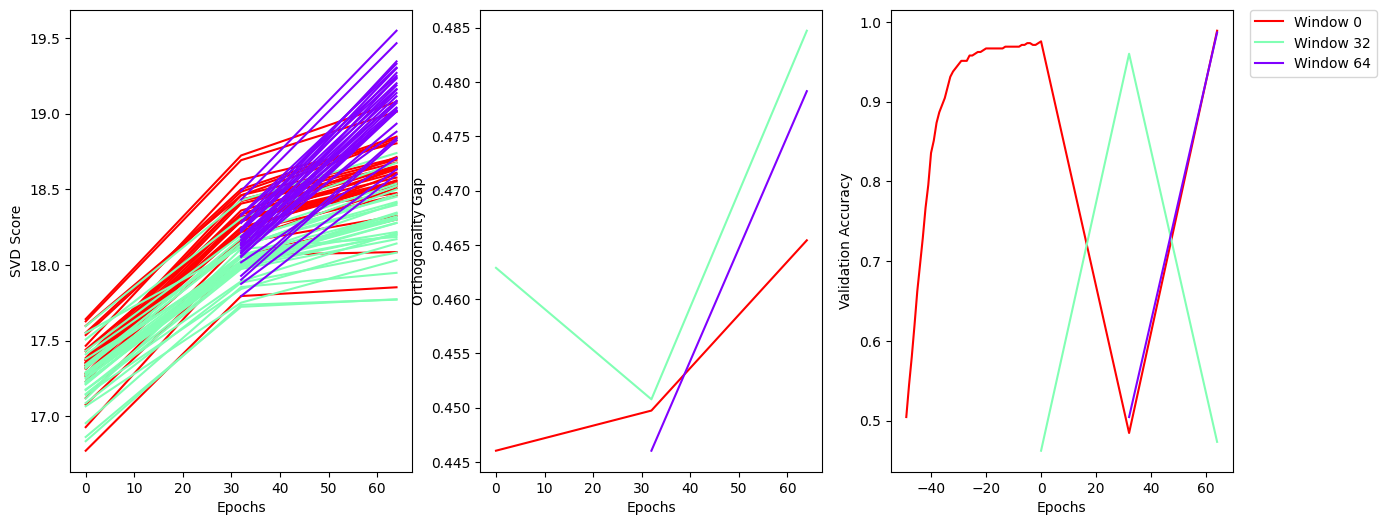

Training 16 epochs per shift, shifting window by 16 indices 4 times
54 55
5 55
4 55
3 55
2 55


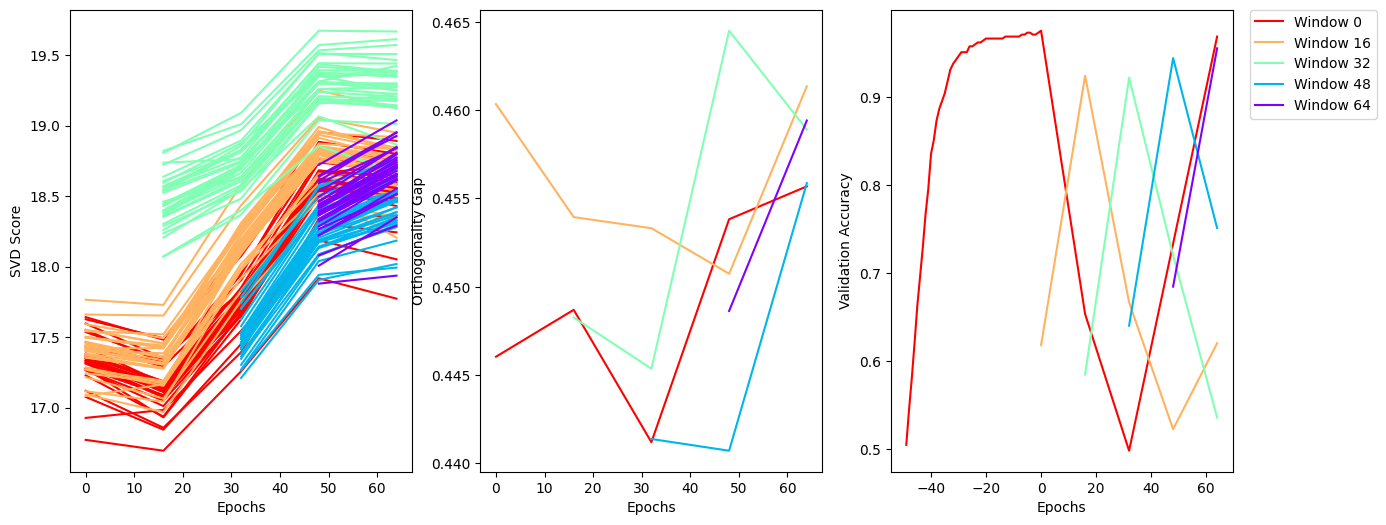

Training 8 epochs per shift, shifting window by 8 indices 8 times
58 59
9 59
8 59
7 59
6 59
5 59
4 59
3 59
2 59


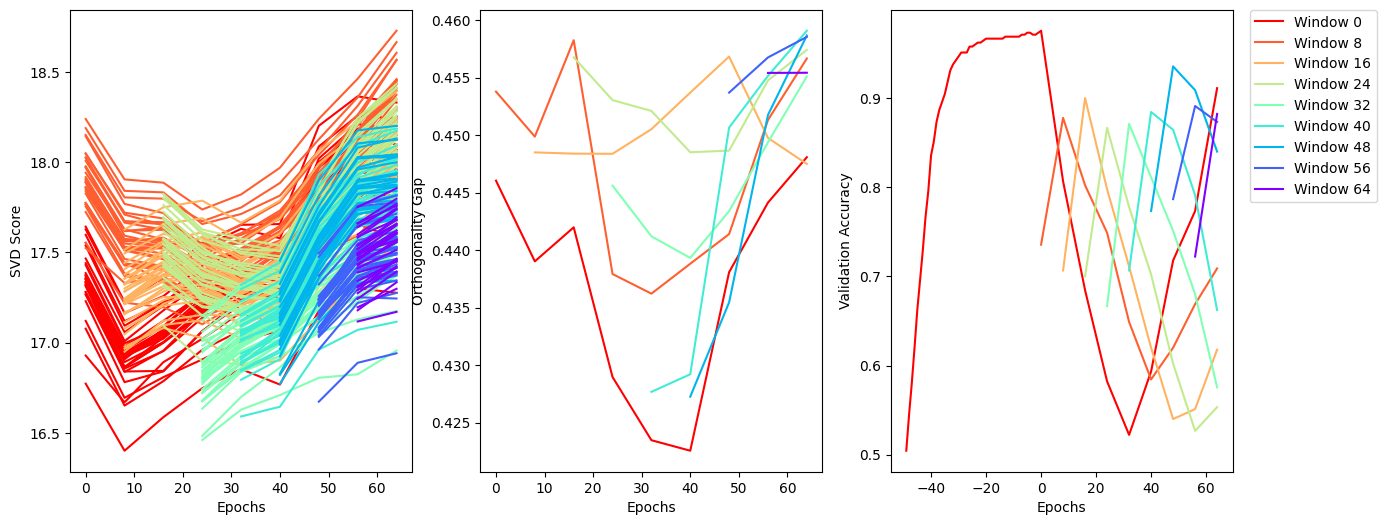

Training 4 epochs per shift, shifting window by 4 indices 16 times
66 67
17 67
16 67
15 67
14 67
13 67
12 67
11 67
10 67
9 67
8 67
7 67
6 67
5 67
4 67
3 67
2 67


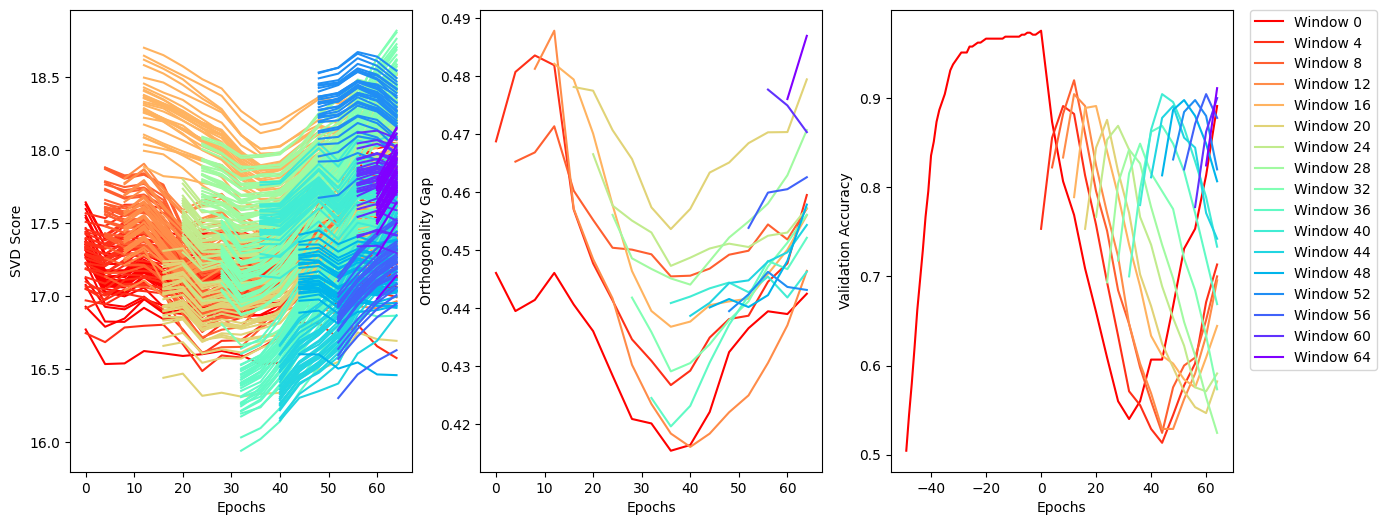

In [16]:
for key, value in model.activations.items():
    print("{}: {:.3f} {}".format(key, effective_rank(value, partial=True).item(), round(orthogonality_gap(value).item(), 1)), end="\t")
print()
print(activation_variance(model.activations["0"]))

cmap = plt.get_cmap('rainbow')

for power in range(int(math.log(base_data.input_dim, 2))-2):
    mod = copy.deepcopy(model)
    mod_optimizer = torch.optim.SGD(mod.parameters(), lr=0.01)
    mod_optimizer.load_state_dict(optimizer.state_dict())

    loss, acc = test(mod, val_loader, criterion, device=device, regression=regression, verbose=False)
    accs = [list(pre_accs)]
    svd_scores = [svd_score(mod.activations["0"]).unsqueeze(0)]
    orthog_gaps = [[orthogonality_gap(mod.activations["0"])]]

    timestamp = list(range(-50, 1))

    shift = 2**(int(math.log(base_data.input_dim, 2))-power-1)
    datasets = [val_loader]
    
    print("Training {} epochs per shift, shifting window by {} indices {} times".format(64//int(base_data.input_dim/shift), shift, int(base_data.input_dim/shift)))
    for step in range(int(base_data.input_dim/shift)):
        modded_data = copy.deepcopy(base_data)
        #modded_data.shift_distribution(adder=((step+1)*shift)/32)
        modded_data.shift_window((step+1)*shift)
        modded_train_loader, modded_val_loader, modded_test_loader = split_dataset(modded_data, val_size = 0.1, test_size = 0.1, batch_size = 128)
        datasets.append(modded_val_loader)
        loss, acc = test(mod, modded_val_loader, criterion, device=device, regression=regression, verbose=False)
        accs.append([acc])
        svd_scores.append(svd_score(mod.activations["0"]).unsqueeze(0))
        orthog_gaps.append([orthogonality_gap(mod.activations["0"])])
        train(mod, modded_train_loader, mod_optimizer, criterion, epochs=64//int(base_data.input_dim/shift), val_loader=modded_val_loader, device=device, regression=regression, verbose=False, val_verbose=False)
        timestamp.append(timestamp[-1]+64//int(base_data.input_dim/shift))
        for i, vl in enumerate(datasets):
            loss, acc = test(mod, vl, criterion, device=device, regression=regression, verbose=False)
            accs[i].append(acc)
            svd_scores[i] = torch.cat((svd_scores[i], svd_score(mod.activations["0"]).unsqueeze(0)), dim=0)
            orthog_gaps[i].append(orthogonality_gap(mod.activations["0"]))

    #plot the svd scores
    colors = [cmap(i) for i in np.linspace(1, 0, len(svd_scores))]
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
    for i, scores in enumerate(svd_scores):
        for neuron in range(scores.shape[1]):
            ax1.plot(timestamp[-len(scores[:,neuron]):], scores[:,neuron], color=colors[i], label="Window {}".format(int(i*(64//(len(svd_scores)-1)))) if neuron == 0 else None)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("SVD Score")
    for i, gaps in enumerate(orthog_gaps):
        ax2.plot(timestamp[-len(gaps):], gaps, color=colors[i], label="Window {}".format(int(i*(64//(len(svd_scores)-1)))))
        print(len(accs[i]), len(timestamp))
        ax3.plot(timestamp[-len(accs[i]):], accs[i], color=colors[i], label="Window {}".format(int(i*(64//(len(svd_scores)-1)))))
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Orthogonality Gap")
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("Validation Accuracy")
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    #print(datasets[0].dataset.y == datasets[-1].dataset.y)

['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']


In [20]:

for key, value in model.activations.items():
    print("{}: {:.3f} {}".format(key, effective_rank(value, partial=True).item(), round(orthogonality_gap(value).item(), 1)), end="\t")
print()
print(activation_variance(model.activations["0"]))

for power in range(int(math.log(base_data.input_dim, 2))):
    mod = copy.deepcopy(model)
    mod_optimizer = torch.optim.SGD(mod.parameters(), lr=0.01)
    mod_optimizer.load_state_dict(optimizer.state_dict())

    shift = 2**(int(math.log(base_data.input_dim, 2))-power-1)
    datasets = [val_loader]
    
    print("Training {} epochs per shift, shifting window by {} indices {} times".format(64//int(base_data.input_dim/shift), shift, int(base_data.input_dim/shift)))
    for step in range(int(base_data.input_dim/shift)-2):
        modded_data = copy.deepcopy(base_data)
        modded_data.shift_distribution(adder=((step+1)*shift)/32)
        modded_train_loader, modded_val_loader, modded_test_loader = split_dataset(modded_data, val_size = 0.1, test_size = 0.1, batch_size = 128)
        datasets.append(modded_val_loader)
        train(mod, modded_train_loader, mod_optimizer, criterion, epochs=64//int(base_data.input_dim/shift), val_loader=modded_val_loader, device=device, regression=regression, verbose=False, val_verbose=False)
        for key, value in mod.activations.items():
            print("{}: {:.3f} {}".format(key, effective_rank(value, partial=True).item(), round(orthogonality_gap(value).item(), 1)), end="\t")
        print()
        print(activation_variance(mod.activations["0"]))
    print()
    for vl in datasets:
        test(mod, vl, criterion, device=device, regression=regression, metrics=True)
        print(", ", end="")
        for key, value in mod.activations.items():
            print("{}: {:.3f} {}".format(key, effective_rank(value, partial=True).item(), round(orthogonality_gap(value).item(), 1)), end="\t")
        print()

-1: 147.673 10035187.0	0: 27.996 61267.8	1: 10.830 37350.9	
tensor([0.3890, 0.1954, 0.3459, 0.7973, 0.0509, 0.0724, 0.5273, 1.0188, 0.2346,
        0.2770, 0.0758, 0.5836, 0.4636, 0.2153, 0.0439, 0.3187])
Training 32 epochs per shift, shifting window by 32 indices 2 times

Average loss: 0.0006, Accuracy: 441/450 (98.00%), -1: 148.387 10411235.0	0: 27.487 37009.5	1: 10.928 4919.5	
Training 16 epochs per shift, shifting window by 16 indices 4 times
-1: 153.016 27416778.0	0: 27.821 162292.7	1: 11.521 49009.5	
tensor([0.3826, 0.1743, 0.2553, 0.7024, 0.0160, 0.0608, 0.7669, 0.0407, 0.3740,
        0.0373, 0.0506, 0.8039, 0.0557, 0.0803, 0.0098, 0.3845])
-1: 158.604 137106736.0	0: 29.125 611025.4	1: 11.399 46775.6	
tensor([5.7181e-01, 3.6290e-01, 3.7468e-01, 1.0576e+00, 1.6687e-02, 1.7783e-01,
        5.4202e-01, 7.7298e-03, 3.9424e-01, 1.1267e-03, 2.6353e-01, 1.0275e+00,
        4.0696e-04, 4.6207e-02, 6.2630e-04, 5.6467e-01])

Average loss: 0.0044, Accuracy: 308/450 (68.44%), -1: 148.421 1